<a href="https://colab.research.google.com/github/dswh/lil_nlp_with_tensorflow/blob/main/03_03_begin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improving the performance of the Text Classifier with CNN

This notebook covers tries to explore the CNN model by replacing the LSTM model implemented in the previous video. We'll compare the accuracy and loss for a CNN model on the same headlines data.

In [1]:
##import the required libraries and APIs
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2025-07-18 11:48:06.095919: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-18 11:48:06.096468: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-18 11:48:06.099745: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-18 11:48:06.108462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752839286.123166   26715 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752839286.13

2.19.0


## Downloading the headlines data



In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/wdd-2-node.appspot.com/x1.json \
    -o /tmp/headlines.json

In [3]:
import pandas as pd

data = pd.read_json("./Sarcasm_Headlines_Dataset_v2_fixed.json")
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
##create arrays to store the headlines and labels
headlines = list(data['headline'])
labels = list(data['is_sarcastic'])

In [23]:
##define tokenizing and padding parameters
vocab_size = 10000
max_length = 150
embedding_dim = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [24]:
##training set from 0 to training size
training_sentences = headlines[0:training_size]
training_labels = labels[0:training_size]

##testing set from training size to the end
testing_sentences = headlines[training_size:]
testing_labels = labels[training_size:]

In [25]:
##train the tokenizer on training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

##create training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

##create test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [26]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

## Define the neural network model with the following layers:
1. Embedding layer
2. Replace the bidirectional LSTM layers with convolutional layers with a filter size of 5.
3. GlovalAveragePooling Layer to down sample the feature map.
3. Dense layer with 24 nodes
4. Output Dense layer with `sigmoid` activation 

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
num_epochs = 5
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/5
625/625 - 5s - 7ms/step - accuracy: 0.6660 - loss: 0.5863 - val_accuracy: 0.8042 - val_loss: 0.4165
Epoch 2/5
625/625 - 4s - 6ms/step - accuracy: 0.8564 - loss: 0.3372 - val_accuracy: 0.8347 - val_loss: 0.3636
Epoch 3/5
625/625 - 4s - 6ms/step - accuracy: 0.9039 - loss: 0.2449 - val_accuracy: 0.8394 - val_loss: 0.3674
Epoch 4/5
625/625 - 4s - 6ms/step - accuracy: 0.9262 - loss: 0.1929 - val_accuracy: 0.8349 - val_loss: 0.3891
Epoch 5/5
625/625 - 4s - 6ms/step - accuracy: 0.9443 - loss: 0.1556 - val_accuracy: 0.8371 - val_loss: 0.4196


## Visualize the accuracy and loss

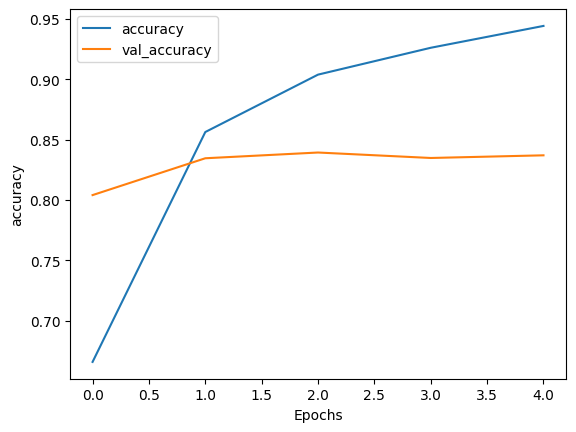

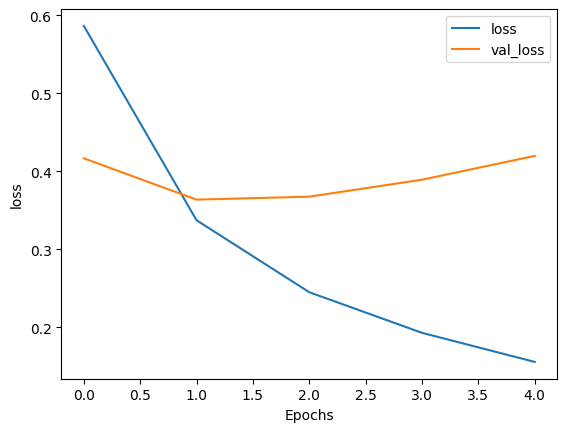

In [29]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Classifying new sentences

In [30]:
sentence = ["the girl starting to fear snakes in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
[[0.07160144]
 [0.02990978]]
